# Important Variable

In [211]:
!jupyter nbconvert --to script model_build.ipynb

import csv
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import neurokit2 as nk
from scipy.signal import butter, filtfilt
from scipy.signal import resample

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


import tensorflow as tf
from tqdm.notebook import tqdm
from tensorflow.python.client import device_lib

[NbConvertApp] Converting notebook model_build.ipynb to script
[NbConvertApp] Writing 22225 bytes to model_build.py


In [2]:
print(tf.__version__)

2.16.2


In [5]:
tf.config.experimental.list_physical_devices('GPU')
device_lib.list_local_devices()

2024-06-30 15:51:24.387646: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:0 with 22757 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1b:00.0, compute capability: 7.5
2024-06-30 15:51:24.388079: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:1 with 22757 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:1c:00.0, compute capability: 7.5
2024-06-30 15:51:24.388494: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:2 with 22757 MB memory:  -> device: 2, name: Quadro RTX 6000, pci bus id: 0000:1d:00.0, compute capability: 7.5
2024-06-30 15:51:24.388915: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:3 with 22757 MB memory:  -> device: 3, name: Quadro RTX 6000, pci bus id: 0000:1e:00.0, compute capability: 7.5
2024-06-30 15:51:24.389340: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /dev

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14705992216478321529
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 23862837248
 locality {
   bus_id: 1
   links {
     link {
       device_id: 1
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 2
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 3
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 4
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 5
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 6
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 7
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 1804134295169556775
 physical_device_desc: "device: 0, name: Quadro RTX 6000, pci bus id: 0000:1b:00.0, compute capabi

In [6]:
MODEL_NAME = 'CNN_biLSTM_30seconds'
RUN = 'run4_' + MODEL_NAME+ '/'

CURRENT_DIR = os.getcwd()
DATA_DIR = CURRENT_DIR + '/dataset/'
MASTER_OUTPUT_DIR = CURRENT_DIR + '/output/'
OUTPUT_DIR = MASTER_OUTPUT_DIR + RUN
print(DATA_DIR)
print(OUTPUT_DIR)

/nfs/ada/jbrook1/users/qdang1/Fantasia_respiration/dataset/
/nfs/ada/jbrook1/users/qdang1/Fantasia_respiration/output/run4_CNN_biLSTM_baseline_30seconds/


# Load data

In [7]:
data_df = pd.read_pickle(DATA_DIR + 'fantasia_dataset_preprocessing.plk')
data_df

,subject_id,chunk_id,ecg,resp,Mean_Respiration_Rate,Total_Area_Peak_to_Trough,Total_Area_Trough_to_Peak,Mean_latency_Trough_to_Peak,Mean_latency_Peak_to_Trough
0,f1o01,0,"[8.46, 8.592, 8.352, 8.152, 8.34, 8.528, 8.312...","[8.488, 8.452, 8.488, 8.496, 8.508, 8.476, 8.4...",14.505123,0.562117,1.169217,1.690667,2.544000
1,f1o01,1,"[8.316, 8.58, 8.664, 8.428, 8.264, 8.444, 8.58...","[8.116, 8.124, 8.092, 8.088, 8.06, 8.064, 8.07...",15.780254,1.146417,0.315799,1.525143,2.221333
2,f1o01,2,"[8.088, 8.088, 8.26, 8.304, 8.144, 8.072, 8.2,...","[8.656, 8.624, 8.608, 8.596, 8.648, 8.652, 8.6...",13.284661,0.353985,0.445506,1.772000,2.860000
3,f1o01,3,"[8.152, 8.02, 8.036, 8.208, 8.208, 8.128, 8.12...","[8.672, 8.684, 8.648, 8.632, 8.628, 8.672, 8.6...",14.913591,0.688938,1.089432,1.680000,2.391000
4,f1o01,4,"[8.068, 8.004, 7.864, 7.9, 8.048, 7.996, 7.848...","[8.548, 8.524, 8.508, 8.528, 8.568, 8.552, 8.5...",16.444328,0.983089,0.837500,1.479200,2.752000
...,...,...,...,...,...,...,...,...,...
9471,f2y10,234,"[-0.01708984375, -0.01220703125, -0.01953125, ...","[0.54443359375, 0.5419921875, 0.5517578125, 0....",15.151441,0.219147,0.206771,1.567200,2.387000
9472,f2y10,235,"[-0.1220703125, -0.23681640625, -0.25390625, -...","[-0.17333984375, -0.1708984375, -0.17333984375...",10.984443,0.493156,0.759228,2.105000,3.357333
9473,f2y10,236,"[0.1025390625, 0.07568359375, 0.0439453125, 0....","[-0.185546875, -0.185546875, -0.1806640625, -0...",14.860658,0.272106,0.304594,1.684667,2.696000
9474,f2y10,237,"[-0.1123046875, -0.107421875, -0.10986328125, ...","[0.0830078125, 0.087890625, 0.0927734375, 0.09...",11.101286,0.637757,1.059193,2.117000,3.465333


# Preprocessing

In [8]:
chunks_df = data_df #allias

In [9]:
chunks_df = chunks_df.dropna(subset=['Mean_Respiration_Rate'])

## Standardization

In [10]:
# Convert 'ecg' column to a 3D numpy array
X = np.array(chunks_df['ecg'].tolist())
Y = chunks_df[['Mean_Respiration_Rate','Total_Area_Trough_to_Peak','Total_Area_Peak_to_Trough',
            'Mean_latency_Trough_to_Peak','Mean_latency_Peak_to_Trough']].values

# Normalize each ECG chunk individually and handle NaNs
X_normalized = np.zeros_like(X)
for i in range(X.shape[0]):
    mean = np.mean(X[i])
    std = np.std(X[i])
    if std == 0:  # Avoid division by zero
        print('sid == 0')
        std = 1
    X_normalized[i] = (X[i] - mean) / std

In [11]:
print(X_normalized.shape)
print(Y.shape)

(8580, 7500)
(8580, 5)


In [12]:
# Remove Nan value
nan_rows = np.isnan(X_normalized).any(axis=1)

# Remove rows with NaNs
X_normalized = X_normalized[~nan_rows]
Y = Y[~nan_rows]
cleaned_chunks_df = chunks_df[~nan_rows]

print(nan_rows.sum())
print(f"NaN in X_normalized after cleaning: {np.isnan(X_normalized).sum()}, Inf in X_normalized: {np.isinf(X_normalized).sum()}")

18
NaN in X_normalized after cleaning: 0, Inf in X_normalized: 0


In [13]:
print(X_normalized.shape)
print(Y.shape)

(8562, 7500)
(8562, 5)


In [14]:
# # Calculate the 2.5th and 97.5th percentiles
# for i in range(Y.shape[1]):
#     lower_percentile = np.percentile(Y[:,i], 0.5)
#     upper_percentile = np.percentile(Y[:,i], 99.5)



#     # Verify the clipping
#     print('\n', i)
#     print(f"1th percentile: {lower_percentile}")
#     print(f"99th percentile: {upper_percentile}")
#     print(f"Before clipping: min = {Y[:,i].min()}, max = {Y[:,i].max()}")
#     # Clip the values in y_train
#     Y[:,i] = np.clip(Y[:,i], lower_percentile, upper_percentile)
#     print(f"After clipping: min = {Y[:,i].min()}, max = {Y[:,i].max()}")

#     # Continue with training the model using y_train_clipped

Spliting

In [15]:
from sklearn.model_selection import train_test_split


subjects = cleaned_chunks_df['subject_id'].unique()
train_val_subjects, test_subjects = train_test_split(subjects, test_size=0.2, random_state=42)
train_subjects, val_subjects = train_test_split(train_val_subjects, test_size=0.15, random_state=42)

# Create boolean masks for train, validation, and test subjects
train_mask = cleaned_chunks_df['subject_id'].isin(train_subjects)
val_mask = cleaned_chunks_df['subject_id'].isin(val_subjects)
test_mask = cleaned_chunks_df['subject_id'].isin(test_subjects)

# Use these masks to create the actual train, validation, and test datasets
train_data = cleaned_chunks_df[train_mask]
val_data = cleaned_chunks_df[val_mask]
test_data = cleaned_chunks_df[test_mask]

# Now you have train, validation, and test datasets based on the subjects


In [16]:
print(train_subjects)
print(val_subjects)
print(test_subjects)

['f2o05' 'f2o09' 'f2o03' 'f1o06' 'f2y10' 'f1y04' 'f2o02' 'f2y02' 'f1y02'
 'f2y04' 'f2y03' 'f1o07' 'f2o06' 'f1y09' 'f1o10' 'f2y06' 'f2o01' 'f2o04'
 'f2y01' 'f2y09' 'f1o04' 'f1o09' 'f1o01' 'f1o02' 'f1o08' 'f2y07' 'f2y05']
['f1y05' 'f2o10' 'f1y01' 'f1o03' 'f1y08']
['f1y10' 'f1y07' 'f1y06' 'f2o07' 'f1o05' 'f1y03' 'f2y08' 'f2o08']


In [17]:
# Apply the masks to create train, validation, and test sets
X_train = np.expand_dims(X_normalized[train_mask], 2)
Y_train = Y[train_mask] 
X_val = np.expand_dims(X_normalized[val_mask], 2)
Y_val = Y[val_mask]
X_test = np.expand_dims(X_normalized[test_mask], 2)
Y_test = Y[test_mask]

# Print shapes of the datasets to verify
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {Y_train.shape}")
print(f"y_val shape: {Y_val.shape}")
print(f"y_test shape: {Y_test.shape}")

X_train shape: (5977, 7500, 1)
X_val shape: (1092, 7500, 1)
X_test shape: (1493, 7500, 1)
y_train shape: (5977, 5)
y_val shape: (1092, 5)
y_test shape: (1493, 5)


In [18]:
output_ranges = np.max(Y_train, axis=0) - np.min(Y_train, axis=0)

# Calculate the inverse of the range to use as scaling factors
scaling_factors = 1 / output_ranges

# Normalize scaling factors to sum up to 1
scaling_factors /= scaling_factors.sum()

print(scaling_factors) 

[0.05509939 0.16653788 0.13339706 0.38244415 0.26252152]


# Build Model

In [159]:
EPOCHS = 200
BATCH_SIZE = 64
PATIENCE = 20

In [179]:
reduce_LR_On_Plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=PATIENCE//2,verbose=1, min_delta=0.00001,)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights = True, mode = 'min')

In [206]:
#create model
def create_CNN_model_5_output(shape, start_neuron = 64, kernel_size=9, strides_size=1, max_pool_size=3, dropout=0.3, padding='valid', delta=1.0):    
    input_layer = tf.keras.Input((shape[1], shape[2])) 
    
    conv_1 = tf.keras.layers.Conv1D(start_neuron * 1, kernel_size, strides=strides_size,  padding=padding, activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_layer)
    conv_1 = tf.keras.layers.MaxPool1D(max_pool_size,  padding=padding)(conv_1)
    conv_1 = tf.keras.layers.Dropout(dropout)(conv_1)
    
    conv_2 = tf.keras.layers.Conv1D(start_neuron * 2, kernel_size, strides=strides_size, padding=padding, activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=tf.keras.regularizers.l2(0.01))(conv_1)
    conv_2 = tf.keras.layers.MaxPool1D(max_pool_size,  padding=padding)(conv_2)
    conv_2 = tf.keras.layers.Dropout(dropout)(conv_2)    
    
    conv_3 = tf.keras.layers.Conv1D(start_neuron * 4, kernel_size, strides=strides_size, padding=padding, activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=tf.keras.regularizers.l2(0.01))(conv_2)
    conv_3 = tf.keras.layers.MaxPool1D(max_pool_size,  padding=padding)(conv_3)
    conv_3 = tf.keras.layers.Dropout(dropout)(conv_3)
    
    
    flattern_layer = tf.keras.layers.Flatten()(conv_3)
    flattern_layer = tf.keras.layers.Dense(start_neuron * 2,activation=tf.keras.layers.LeakyReLU())(flattern_layer)
    
#     output_0 = tf.keras.layers.Dense(32,activation='relu',)(flattern_layer)
#     output_0 = tf.keras.layers.Dropout(dropout)(output_0)    
    output_0 = tf.keras.layers.Dense(1,activation='linear',name='mean_rr')(flattern_layer)
    
    
#     output_1 = tf.keras.layers.Dense(32,activation='relu',)(flattern_layer)
#     output_1 = tf.keras.layers.Dropout(dropout)(output_1)    
    output_1 = tf.keras.layers.Dense(1,activation='linear',name='area_t_to_p')(flattern_layer)
    
#     output_2 = tf.keras.layers.Dense(32,activation='relu',)(flattern_layer)
#     output_2 = tf.keras.layers.Dropout(dropout)(output_2)    
    output_2 = tf.keras.layers.Dense(1,activation='linear',name='area_p_to_t')(flattern_layer)
    
#     output_3 = tf.keras.layers.Dense(32,activation='relu',)(flattern_layer)
#     output_3 = tf.keras.layers.Dropout(dropout)(output_3)   
    output_3 = tf.keras.layers.Dense(1,activation='linear',name='time_t_to_p')(flattern_layer)
    
#     output_4 = tf.keras.layers.Dense(32,activation='relu',)(flattern_layer)    
#     output_4 = tf.keras.layers.Dropout(dropout)(output_4)   
    output_4 = tf.keras.layers.Dense(1,activation='linear',name='time_p_to_t')(flattern_layer)

    
    model = tf.keras.Model(input_layer, [output_0,output_1,output_2,output_3,output_4])
    loss_weights = [scaling_factors[0]*5,scaling_factors[1],scaling_factors[2],scaling_factors[3],scaling_factors[4]]   
    model.compile(optimizer = 'adam',loss = [tf.keras.losses.Huber(delta=delta),tf.keras.losses.Huber(delta=delta),tf.keras.losses.Huber(delta=delta),tf.keras.losses.Huber(delta=delta),tf.keras.losses.Huber(delta=delta)],loss_weights=loss_weights)
    return model

In [207]:
#create model
def create_CNN_LSTM_model_5_output(shape, start_neuron = 64, kernel_size=9, strides_size=1, max_pool_size=3, dropout=0.3, padding='valid', delta=1.0):    
    input_layer = tf.keras.Input((shape[1], shape[2])) 
    
    conv_1 = tf.keras.layers.Conv1D(start_neuron * 1, kernel_size, strides=strides_size,  padding=padding, activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_layer)
    conv_1 = tf.keras.layers.MaxPool1D(max_pool_size,  padding=padding)(conv_1)
    conv_1 = tf.keras.layers.Dropout(dropout)(conv_1)
    
    conv_2 = tf.keras.layers.Conv1D(start_neuron * 2, kernel_size, strides=strides_size, padding=padding, activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=tf.keras.regularizers.l2(0.01))(conv_1)
    conv_2 = tf.keras.layers.MaxPool1D(max_pool_size,  padding=padding)(conv_2)
    conv_2 = tf.keras.layers.Dropout(dropout)(conv_2)    
    
    lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron, return_sequences=True))(conv_2)
    lstm_1 = tf.keras.layers.Dropout(dropout)(lstm_1)

    lstm_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(lstm_1)
    lstm_2 = tf.keras.layers.Dropout(dropout)(lstm_2)
    lstm_2 = tf.keras.layers.Flatten()(lstm_2)
    
    output_layer = tf.keras.layers.Dense(start_neuron*2,activation=tf.keras.layers.LeakyReLU())(lstm_2)
    output_layer = tf.keras.layers.Dropout(dropout)(output_layer)
    
    #output_0 = tf.keras.layers.Dense(start_neuron*2,activation='relu')(output_layer)
    output_0 = tf.keras.layers.Dense(1,activation='linear',name='mean_rr')(output_layer)

    #output_1 = tf.keras.layers.Dense(start_neuron*2,activation='relu')(output_layer)
    output_1 = tf.keras.layers.Dense(1,activation='linear',name='area_t_to_p')(output_layer)

    #output_2 = tf.keras.layers.Dense(start_neuron*2,activation='relu')(output_layer)
    output_2 = tf.keras.layers.Dense(1,activation='linear',name='area_p_to_t')(output_layer)

    #output_3 = tf.keras.layers.Dense(start_neuron*2,activation='relu')(output_layer)
    output_3 = tf.keras.layers.Dense(1,activation='linear',name='time_t_to_p')(output_layer)

    #output_4 = tf.keras.layers.Dense(start_neuron*2,activation='relu')(output_layer)
    output_4 = tf.keras.layers.Dense(1,activation='linear',name='time_p_to_t')(output_layer)

    
    model = tf.keras.Model(input_layer, [output_0,output_1,output_2,output_3,output_4])
    loss_weights = [scaling_factors[0]*5,scaling_factors[1],scaling_factors[2],scaling_factors[3],scaling_factors[4]]   
    #loss_weights = [scaling_factors[0]*5,0,0,0,0]  
    model.compile(optimizer = 'adam',loss = [tf.keras.losses.Huber(delta=delta),tf.keras.losses.Huber(delta=delta),tf.keras.losses.Huber(delta=delta),tf.keras.losses.Huber(delta=delta),tf.keras.losses.Huber(delta=delta)],loss_weights=loss_weights)
    return model

In [209]:
model = create_CNN_LSTM_model_5_output(X_train.shape, start_neuron = 64, kernel_size= 11, strides_size=4, 
                                  max_pool_size= 3, dropout=0.3,padding='valid', delta=0.5)
model.summary()

history = model.fit(X_train, [Y_train[:,0],Y_train[:,1],Y_train[:,2],Y_train[:,3],Y_train[:,4]], 
                    validation_data=(X_val, [Y_val[:,0],Y_val[:,1],Y_val[:,2],Y_val[:,3],Y_val[:,4]]), 
                    epochs=EPOCHS, batch_size=BATCH_SIZE,verbose=1, shuffle=True, callbacks=[reduce_LR_On_Plateau,early_stopping])

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_38      │ (None, 7500, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_86 (Conv1D)  │ (None, 1873, 64)  │        768 │ input_layer_38[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_86    │ (None, 624, 64)   │          0 │ conv1d_86[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_176         │ (None, 624, 64)   │          0 │ max_pooling1d_86… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_87 (Conv1D)  │ (None, 154, 128)  │     90,240 │ dropout_176[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_87    │ (None, 51, 128)   │          0 │ conv1d_87[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_177         │ (None, 51, 128)   │          0 │ max_pooling1d_87… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_67    │ (None, 51, 128)   │     98,816 │ dropout_177[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_178         │ (None, 51, 128)   │          0 │ bidirectional_67… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_68    │ (None, 51, 256)   │    263,168 │ dropout_178[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_179         │ (None, 51, 256)   │          0 │ bidirectional_68… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_37          │ (None, 13056)     │          0 │ dropout_179[0][0] │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 128)       │  1,671,296 │ flatten_37[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_180         │ (None, 128)       │          0 │ dense_44[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean_rr (Dense)     │ (None, 1)         │        129 │ dropout_180[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ area_t_to_p (Dense) │ (None, 1)         │        129 │ dropout_180[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ area_p_to_t (Dense) │ (None, 1)         │        129 │ dropout_180[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_t_to_p (Dense) │ (None, 1)         │        129 │ dropout_180[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_p_to_t (Dense) │ (None, 1)         │        129 │ dropout_180[0][0] │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 2,124,933 (8.11 MB)

 Trainable params: 2,124,933 (8.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 1.7760 - val_loss: 0.6139 - learning_rate: 0.0010
Epoch 2/200


KeyboardInterrupt: 

# Evaluation

In [201]:
Y_pred = model.predict(X_test,verbose = 1)
Y_pred

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


[array([[17.446228],
        [17.510368],
        [17.72188 ],
        ...,
        [11.671392],
        [17.907282],
        [17.780672]], dtype=float32),
 array([[0.47341636],
        [0.4506226 ],
        [0.43954736],
        ...,
        [0.4379957 ],
        [0.4560167 ],
        [0.39191803]], dtype=float32),
 array([[0.82123506],
        [0.833665  ],
        [0.8410759 ],
        ...,
        [0.6924856 ],
        [0.8416506 ],
        [0.8146217 ]], dtype=float32),
 array([[1.6406763],
        [1.6620482],
        [1.6418171],
        ...,
        [1.1300637],
        [1.6927967],
        [1.5730584]], dtype=float32),
 array([[2.277075 ],
        [2.2273574],
        [2.3057373],
        ...,
        [1.6017101],
        [2.1965687],
        [2.1372545]], dtype=float32)]

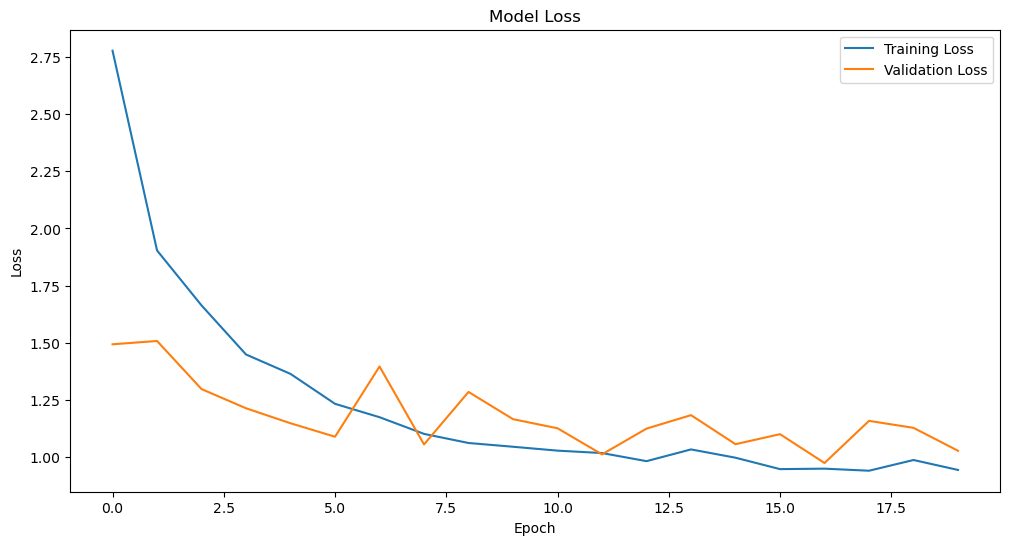

In [202]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# # Plot training & validation MAE values
# plt.figure(figsize=(12, 6))
# plt.plot(history.history['mae'], label='Training MAE')
# plt.plot(history.history['val_mae'], label='Validation MAE')
# plt.title('Model MAE')
# plt.ylabel('MAE')
# plt.xlabel('Epoch')
# plt.legend(loc='upper right')
# plt.show()


In [203]:
Y_test

array([[16.21491429,  0.90752633,  0.41296744,  1.792     ,  2.19      ],
       [13.43430958,  0.69225678,  1.04678768,  1.3056    ,  3.086     ],
       [13.449859  ,  1.80935587,  1.92284876,  1.5248    ,  3.183     ],
       ...,
       [23.71240659,  0.1047237 ,  0.28261164,  1.0928    ,  1.42577778],
       [23.85154228,  0.11579818,  0.19170236,  1.082     ,  1.40666667],
       [22.2237908 ,  0.40859657,  0.55055457,  1.1092    ,  1.62      ]])

In [204]:
Y_pred

[array([[17.446228],
        [17.510368],
        [17.72188 ],
        ...,
        [11.671392],
        [17.907282],
        [17.780672]], dtype=float32),
 array([[0.47341636],
        [0.4506226 ],
        [0.43954736],
        ...,
        [0.4379957 ],
        [0.4560167 ],
        [0.39191803]], dtype=float32),
 array([[0.82123506],
        [0.833665  ],
        [0.8410759 ],
        ...,
        [0.6924856 ],
        [0.8416506 ],
        [0.8146217 ]], dtype=float32),
 array([[1.6406763],
        [1.6620482],
        [1.6418171],
        ...,
        [1.1300637],
        [1.6927967],
        [1.5730584]], dtype=float32),
 array([[2.277075 ],
        [2.2273574],
        [2.3057373],
        ...,
        [1.6017101],
        [2.1965687],
        [2.1372545]], dtype=float32)]

Output 0: Pearson Correlation: 0.21600310847568036
Output 0: P-value: 3.199367350852223e-17
Output 1: Pearson Correlation: -0.08314501602978516
Output 1: P-value: 0.0013019565343364598
Output 2: Pearson Correlation: 0.024149788303823614
Output 2: P-value: 0.3510850295485434
Output 3: Pearson Correlation: -0.05525964498315841
Output 3: P-value: 0.03275771820017557
Output 4: Pearson Correlation: 0.024399420789172423
Output 4: P-value: 0.3461268163172573


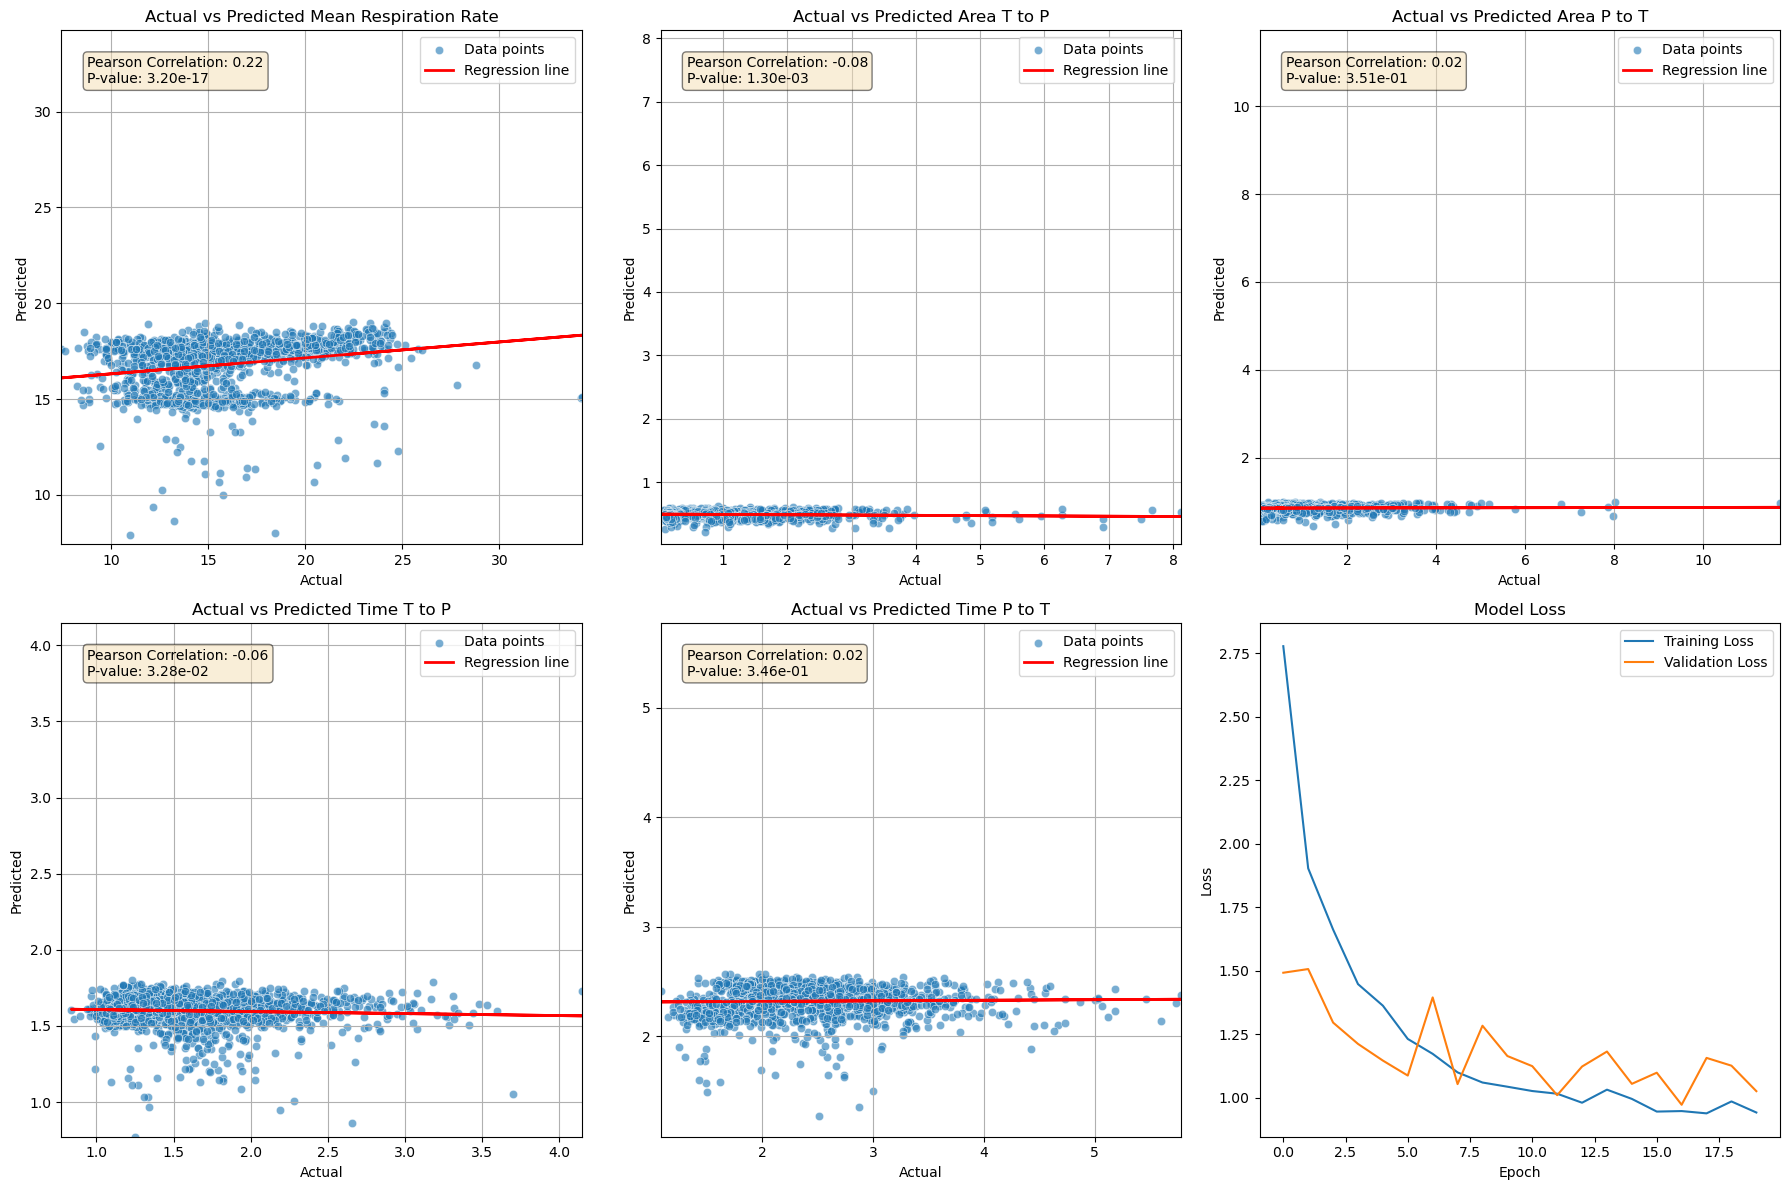

In [205]:
from scipy.stats import pearsonr, linregress

# Initialize the figure and subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()
output_names = ['Mean Respiration Rate', 'Area T to P', 'Area P to T', 'Time T to P', 'Time P to T']


for i in range(5):
    # Calculate the Pearson correlation coefficient
    correlation, p_value = pearsonr(Y_test[:,i], Y_pred[i].flatten())
    print(f"Output {i}: Pearson Correlation: {correlation}")
    print(f"Output {i}: P-value: {p_value}")

    # Create scatter plot
    axes[i].scatter(Y_test[:,i], Y_pred[i].flatten(), alpha=0.6, edgecolors='w', linewidth=0.5, label='Data points')

    # Calculate the regression line
    slope, intercept, r_value, p_value, std_err = linregress(Y_test[:,i], Y_pred[i].flatten())
    regression_line = slope * Y_test[:,i] + intercept
    axes[i].plot(Y_test[:,i], regression_line, color='red', linewidth=2, label='Regression line')

    axes[i].set_title(f'Actual vs Predicted {output_names[i]}')
    axes[i].set_xlabel('Actual')
    axes[i].set_ylabel('Predicted')
    axes[i].grid(True)
    axes[i].legend()

    # Add text box with correlation and p-value
    textstr = f'Pearson Correlation: {correlation:.2f}\nP-value: {p_value:.2e}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    axes[i].text(0.05, 0.95, textstr, transform=axes[i].transAxes, fontsize=10,
                 verticalalignment='top', bbox=props)
    
axes[5].plot(history.history['loss'], label='Training Loss')
axes[5].plot(history.history['val_loss'], label='Validation Loss')
axes[5].set_title('Model Loss')
axes[5].set_ylabel('Loss')
axes[5].set_xlabel('Epoch')
axes[5].legend(loc='upper right')


# Adjust layout to prevent overlap
plt.tight_layout()

# Ensure x and y axes have the same scale
for i, ax in enumerate(axes):
    if i < len(output_names):
        ax.set_xlim([min(Y_test[:,i].min(), Y_pred[i].min()), max(Y_test[:,i].max(), Y_pred[i].max())])
        ax.set_ylim([min(Y_test[:,i].min(), Y_pred[i].min()), max(Y_test[:,i].max(), Y_pred[i].max())])

plt.show()

# Grid Search

In [210]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scipy.stats import pearsonr, linregress
import matplotlib.pyplot as plt


if(not(os.path.exists(OUTPUT_DIR))):
    os.makedirs(OUTPUT_DIR)
    
# Define the grid search parameters
param_grid = {
    'start_neuron': [16],
    'kernel_size': [7],
    'strides_size': [1],
    'max_pool_size': [2],
    'dropout': [0.3],
    'padding' :['same'],
    'batch_size' : [32],
    'huber_delta' : [0.5,1],
}

# Prepare callbacks


# Number of epochs
EPOCHS = 200
PATIENCE = 20

# Initialize a list to store the loss history for all configurations
loss_history = []

# Perform grid search
for start_neuron in param_grid['start_neuron']:
    for kernel_size in param_grid['kernel_size']:
        for strides_size in param_grid['strides_size']:
            for max_pool_size in param_grid['max_pool_size']:
                for dropout in param_grid['dropout']:
                    for padding in param_grid['padding']:
                        for batch_size in param_grid['batch_size']:
                            for delta in param_grid['huber_delta']:
                                print(f'start_neuron={start_neuron}, kernel_size={kernel_size}, strides_size={strides_size}, max_pool_size={max_pool_size}, dropout={dropout}, padding={padding}, batch_size={batch_size}, huber_delta={delta}')
                                
                                reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=PATIENCE//2,verbose=1, min_delta=0.00001,)
                                early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights = True, mode = 'min')
                                # Create the model
                                model = create_CNN_model_5_output(X_train.shape, start_neuron=start_neuron, kernel_size=kernel_size,
                                                                  strides_size=strides_size, max_pool_size=max_pool_size, 
                                                                  dropout=dropout, padding=padding, delta=delta)
                                #model.summary()
    
    
                                # Train the model
                                history = model.fit(X_train, [Y_train[:,0],Y_train[:,1],Y_train[:,2],Y_train[:,3],Y_train[:,4]], 
                                                    validation_data=(X_val, [Y_val[:,0],Y_val[:,1],Y_val[:,2],Y_val[:,3],Y_val[:,4]]), 
                                                    epochs=EPOCHS, batch_size=BATCH_SIZE,verbose=0, shuffle=True, 
                                                    callbacks=[early_stopping, reduce_lr])
                                min_train_loss = min(history.history['loss'])
                                min_val_lost = min(history.history['val_loss'])
                                # Save loss history for the current configuration
                                config_loss_history = {
                                    'config': f'start_neuron={start_neuron}, kernel_size={kernel_size}, strides_size={strides_size}, max_pool_size={max_pool_size}, dropout={dropout}, padding={padding}, batch_size={batch_size}, huber_delta={delta}',
                                    'training_loss': history.history['loss'],
                                    'validation_loss': history.history['val_loss'],
                                    'min' : f'Best_train_loss{min_train_loss}, best_val_loss{min_val_lost}'
                                }
                                loss_history.append(config_loss_history)
    
                                # Evaluate the model
                                Y_pred = model.predict(X_test)
    
                                # Create plots
                                fig, axes = plt.subplots(2, 3, figsize=(18, 12))
                                axes = axes.flatten()
                                output_names = ['Mean Respiration Rate', 'Area T to P', 'Area P to T', 'Time T to P', 'Time P to T']
    
                                for i in range(5):
                                    # Calculate the Pearson correlation coefficient
                                    correlation, p_value = pearsonr(Y_test[:,i], Y_pred[i].flatten())
    
    
                                    # Create scatter plot
                                    axes[i].scatter(Y_test[:,i], Y_pred[i].flatten(), alpha=0.6, edgecolors='w', linewidth=0.5, label='Data points')
    
                                    # Calculate the regression line
                                    slope, intercept, r_value, p_value, std_err = linregress(Y_test[:,i], Y_pred[i].flatten())
                                    regression_line = slope * Y_test[:,i] + intercept
                                    axes[i].plot(Y_test[:,i], regression_line, color='red', linewidth=2, label='Regression line')
    
                                    axes[i].set_title(f'Actual vs Predicted {output_names[i]}')
                                    axes[i].set_xlabel('Actual')
                                    axes[i].set_ylabel('Predicted')
                                    axes[i].grid(True)
                                    axes[i].legend()
    
                                    # Add text box with correlation and p-value
                                    textstr = f'Pearson Correlation: {correlation:.2f}\nP-value: {p_value:.2e}'
                                    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
                                    axes[i].text(0.05, 0.95, textstr, transform=axes[i].transAxes, fontsize=10,
                                                 verticalalignment='top', bbox=props)
    
                                # Adjust layout to prevent overlap
                                plt.tight_layout()
    
                                # Ensure x and y axes have the same scale
                                for i, ax in enumerate(axes):
                                    if i < len(output_names):
                                        ax.set_xlim([min(Y_test[:,i].min(), Y_pred[i].min()), max(Y_test[:,i].max(), Y_pred[i].max())])
                                        ax.set_ylim([min(Y_test[:,i].min(), Y_pred[i].min()), max(Y_test[:,i].max(), Y_pred[i].max())])
    
                                # Save the plot
                                plt.savefig(OUTPUT_DIR + f'grid_search_{start_neuron}_{kernel_size}_{strides_size}_{max_pool_size}_{dropout}_{padding}_{batch_size}_{delta}.png')
                                plt.close()

# Save loss history to a text file
with open(OUTPUT_DIR + 'loss_history.txt', 'w') as f:
    for entry in loss_history:
        f.write(f"Configuration: {entry['config']}\n")
        f.write(f"Training Loss: {entry['training_loss']}\n")
        f.write(f"Validation Loss: {entry['validation_loss']}\n")
        f.write(f"{entry['min']}\n")
        f.write("\n")

print("Grid search completed and results saved.")

start_neuron=16, kernel_size=7, strides_size=1, max_pool_size=2, dropout=0.3, padding=same, batch_size=32, huber_delta=0.5

Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 47: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
start_neuron=16, kernel_size=7, strides_size=1, max_pool_size=2, dropout=0.3, padding=same, batch_size=32, huber_delta=1

Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 44: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Grid search completed and results saved.


In [ ]:
param_grid = {
    'start_neuron': [32,64],
    'kernel_size': [5,7,9,11],
    'strides_size': [1,2,3,4],
    'max_pool_size': [2,3],
    'dropout': [0.3,0.4,0.5],
    'padding' :['same','valid'],
    'batch_size' : [64],
    'huber_delta' : [0.5,1],
    
}